**Module Path**

In [1]:
import os

os.chdir("./../..")

# Monte Carlo Methods

In this notebook, we will implement many Monte Carlo (MC) algorithms. 

### Part 0: Explore BlackjackEnv

We begin by importing the necessary packages.

In [2]:
import numpy as np
from pyvirtualdisplay import Display

display = Display(visible=0, size=(1400, 900))
display.start()

from examples.blackjack.plot_utils import plot_blackjack_values, plot_policy

In [3]:
from env import Environment
from policy import RandomPolicy

Use the code cell below to create an instance of the [Blackjack](https://github.com/openai/gym/blob/master/gym/envs/toy_text/blackjack.py) environment.

In [4]:
env = Environment("blackjack")

Each state is a 3-tuple of:
- the player's current sum $\in \{0, 1, \ldots, 31\}$,
- the dealer's face up card $\in \{1, \ldots, 10\}$, and
- whether or not the player has a usable ace (`no` $=0$, `yes` $=1$).

The agent has two potential actions:

```
    STICK = 0
    HIT = 1
```
Verify this by running the code cell below.

In [5]:
print(env.get_observation_space())
print(env.get_action_space())

Tuple(Discrete(32), Discrete(11), Discrete(2))
Discrete(2)


Execute the code cell below to play Blackjack with a random policy.  

Score:  -1.0
Score:  -1.0
Score:  -1.0


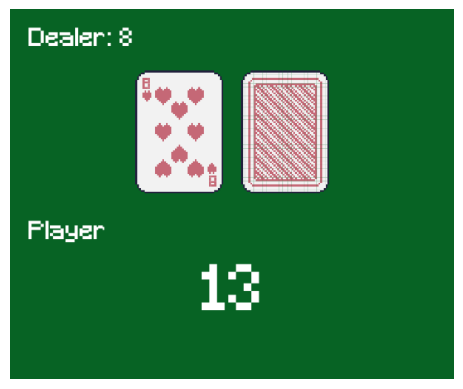

In [6]:
random_policy = RandomPolicy(env.get_action_space())

num_times = 3

for _ in range(num_times):
    env.watch(random_policy, display)

# Part 1: MC Prediction

In this section, we will implement MC prediction (for estimating the action-value function).  

We will begin by investigating a policy where the player _almost_ always sticks if the sum of her cards exceeds 18.  In particular, she selects action `STICK` with 80% probability if the sum is greater than 18; and, if the sum is 18 or below, she selects action `HIT` with 80% probability.  The function `generate_episode_from_limit_stochastic` samples an episode using this policy. 

The function accepts as **input**:
- `bj_env`: This is an instance of OpenAI Gym's Blackjack environment.

It returns as **output**:
- `episode`: This is a list of (state, action, reward) tuples (of tuples) and corresponds to $(S_0, A_0, R_1, \ldots, S_{T-1}, A_{T-1}, R_{T})$, where $T$ is the final time step.  In particular, `episode[i]` returns $(S_i, A_i, R_{i+1})$, and `episode[i][0]`, `episode[i][1]`, and `episode[i][2]` return $S_i$, $A_i$, and $R_{i+1}$, respectively.

In [7]:
def generate_episode_from_limit_stochastic(bj_env):
    episode = []
    state = bj_env.reset()[0]
    while True:
        probs = [0.8, 0.2] if state[0] > 18 else [0.2, 0.8]
        action = np.random.choice(np.arange(2), p=probs)
        next_state, reward, done, _, _ = bj_env.step(action)
        episode.append((state, action, reward))
        state = next_state
        if done:
            break
    return episode

Execute the code cell below to play Blackjack with the policy.

In [8]:
for i in range(3):
    print(generate_episode_from_limit_stochastic(env))

[((20, 8, False), np.int64(1), -1.0)]
[((13, 10, False), np.int64(1), -1.0)]
[((13, 5, False), np.int64(1), -1.0)]


Let's implement first, first-visit and then every-visit MC prediction; in the case of the Blackjack environment, the techniques are equivalent.

The algorithm has three arguments:
- `env`: This is an instance of an OpenAI Gym environment.
- `num_episodes`: This is the number of episodes that are generated through agent-environment interaction.
- `generate_episode`: This is a function that returns an episode of interaction.
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).

The algorithm returns as output:
- `Q`: This is a dictionary (of one-dimensional arrays) where `Q[s][a]` is the estimated action value corresponding to state `s` and action `a`.

## **Algorithm:** First-Visit MC Prediction (*for state values*)

**Input:** policy $ \pi $, positive integer $ \text{num\_episodes} $  
**Output:** value function $ V \approx v_{\pi} $ if $ \text{num\_episodes} $ is large enough  

1. Initialize $ N(s) = 0 $ for all $ s \in S $  
2. Initialize $ \text{returns\_sum}(s) = 0 $ for all $ s \in S $  
3. **for** $ i \leftarrow 1 $ **to** $ \text{num\_episodes} $ **do**  
   1. Generate an episode $ S_0, A_0, R_1, \ldots, S_T $ using $ \pi $  
   2. **for** $ t \leftarrow 0 $ **to** $ T - 1 $ **do**  
      1. **if** $ S_t $ is a first visit (with return $ G_t $) **then**  
         1. $ N(S_t) \leftarrow N(S_t) + 1 $  
         2. $ \text{returns\_sum}(S_t) \leftarrow \text{returns\_sum}(S_t) + G_t $  
4. **end for**  
5. $ V(s) \leftarrow \text{returns\_sum}(s) / N(s) $ for all $ s \in S $  
6. **return** $ V $  


In [9]:
from qtable import DictionaryQTable
from policy import FirstVisitMCPolicy

q_table = DictionaryQTable()
q_table.initialize(env.get_action_space().n)
policy = FirstVisitMCPolicy(q_table, env.get_action_space())

Use the cell below to obtain the action-value function estimate $Q$.  We have also plotted the corresponding state-value function.

In [10]:
from train import TrainerMC

In [11]:
trainer = TrainerMC(policy, env)
trainer.train(50_000)

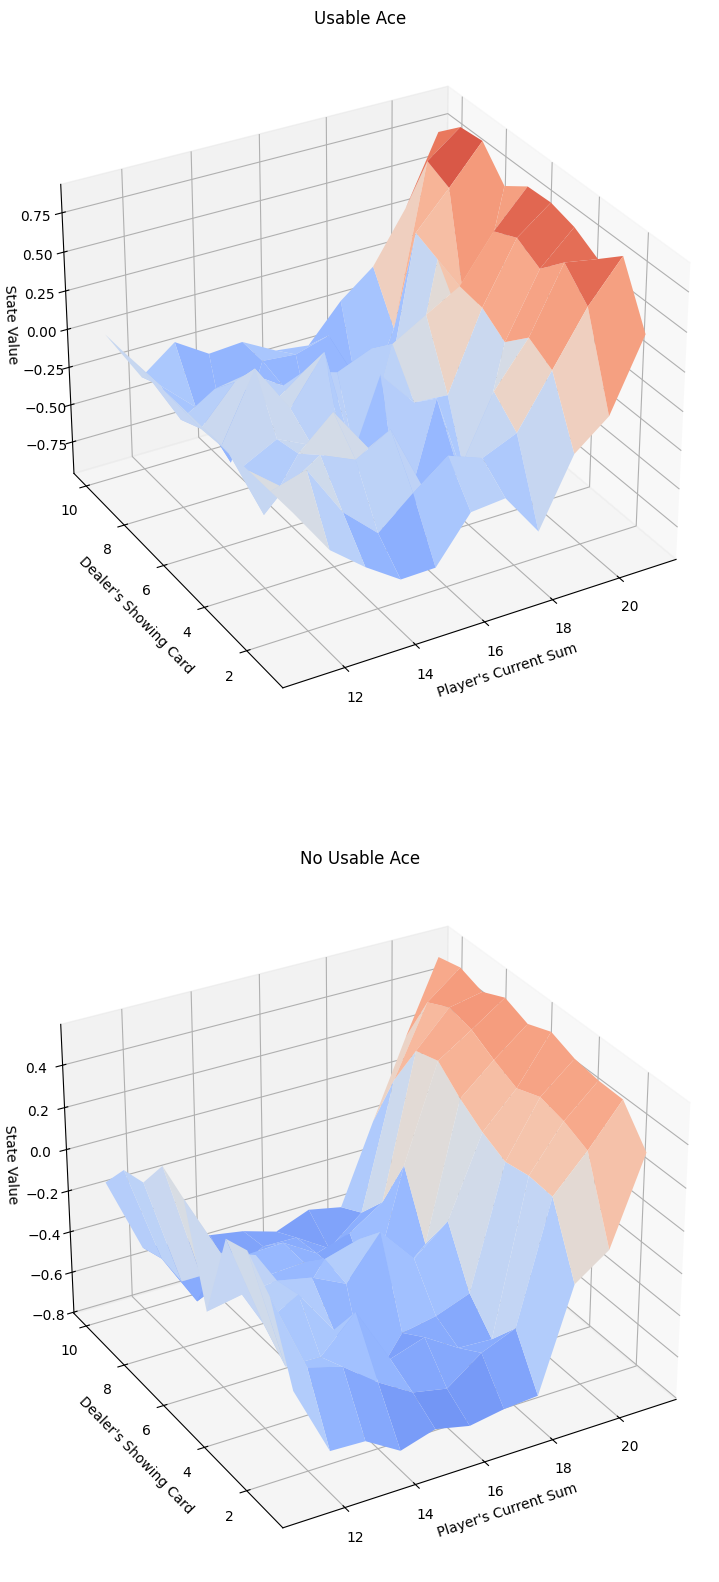

In [12]:
# obtain the corresponding state-value function
V_to_plot = dict(
    (k, (k[0] > 18) * (np.dot([0.8, 0.2], v)) + (k[0] <= 18) * (np.dot([0.2, 0.8], v)))
    for k, v in q_table.q_values.items()
    if isinstance(k, tuple)
)

# plot the state-value function
plot_blackjack_values(V_to_plot)

In [13]:
n = 50_000
average_reward = trainer.evaluate(n)
n_diff = average_reward * n

# Calculate the number of wins and losses based on n_diff
if n_diff > 0:
    n_losses = (n + n_diff) / 2
    n_wins = n - n_losses
else:
    n_wins = (n - n_diff) / 2
    n_losses = n - n_wins

# Calculate win and loss percentages
win_percentage = (n_wins / n) * 100
loss_percentage = (n_losses / n) * 100

# Print results with percentages
print(f"Win %: {win_percentage:.2f}%")
print(f"Loss %: {loss_percentage:.2f}%")

Evaluation: Average reward over 50000 episodes: -0.09818
Win %: 54.91%
Loss %: 45.09%


## **Algorithm:** Every-Visit MC Prediction (*for state values*)

**Input:** policy $ \pi $, positive integer $ \text{num\_episodes} $  
**Output:** value function $ V \approx v_{\pi} $ if $ \text{num\_episodes} $ is large enough  

1. Initialize $ N(s) = 0 $ for all $ s \in S $  
2. Initialize $ \text{returns\_sum}(s) = 0 $ for all $ s \in S $  
3. **for** $ i \leftarrow 1 $ **to** $ \text{num\_episodes} $ **do**  
   1. Generate an episode $ S_0, A_0, R_1, S_1, A_1, R_2, \ldots, S_T $ using $ \pi $  
   2. **for** $ t \leftarrow 0 $ **to** $ T - 1 $ **do**  
      1. Calculate the return $ G_t $ from step $ t $:
         - $ G_t = \sum_{k=0}^{T-t} \gamma^k \cdot R_{t+k+1} $  
      2. Increment $ N(S_t) \leftarrow N(S_t) + 1 $  
      3. Update $ \text{returns\_sum}(S_t) \leftarrow \text{returns\_sum}(S_t) + G_t $  
4. **end for**  
5. $ V(s) \leftarrow \text{returns\_sum}(s) / N(s) $ for all $ s \in S $  
6. **return** $ V $  


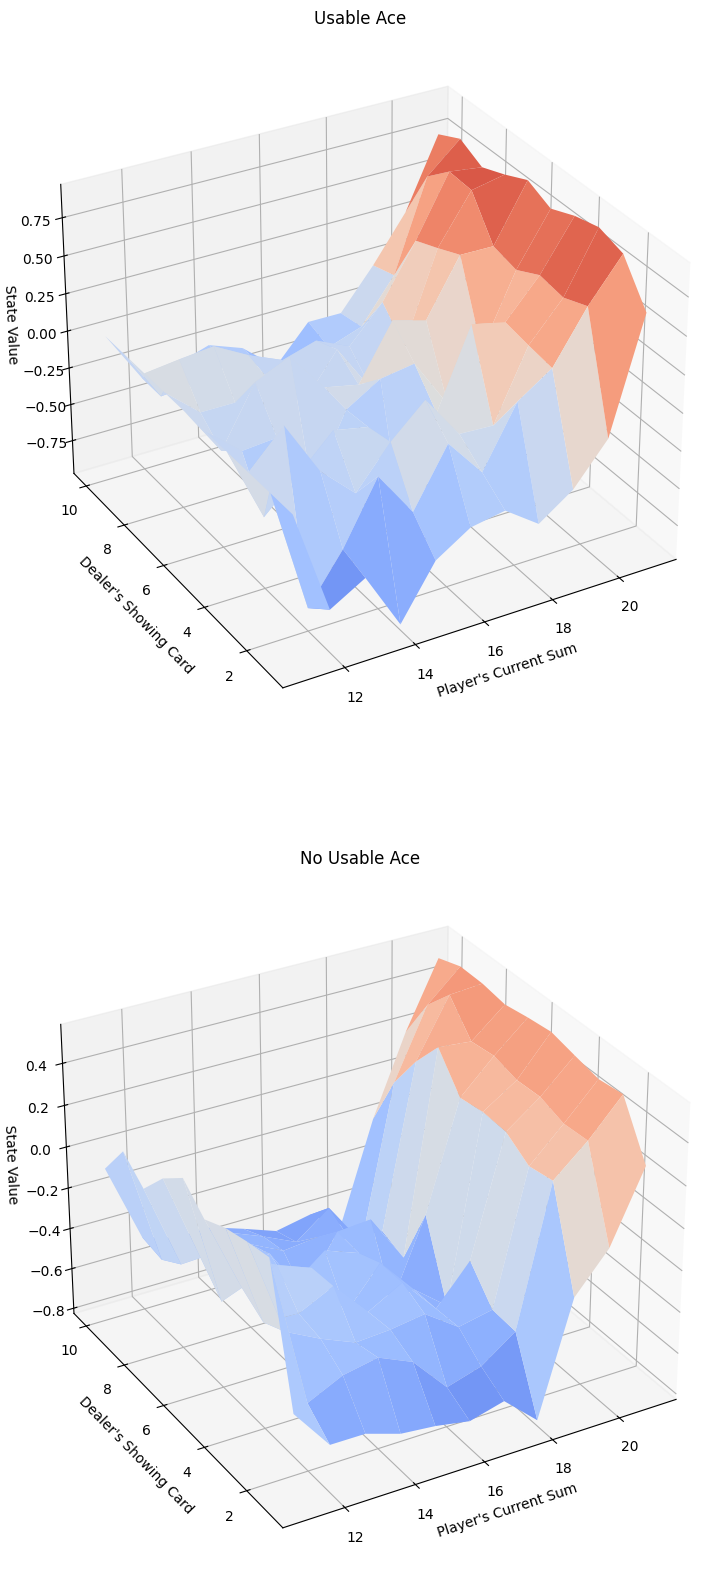

In [14]:
from policy import EveryVisitMCPolicy

q_table = DictionaryQTable()
q_table.initialize(env.get_action_space().n)

policy = EveryVisitMCPolicy(q_table, env.get_action_space())

trainer = TrainerMC(policy, env)
trainer.train(50_000)

# obtain the corresponding state-value function
V_to_plot = dict(
    (k, (k[0] > 18) * (np.dot([0.8, 0.2], v)) + (k[0] <= 18) * (np.dot([0.2, 0.8], v)))
    for k, v in q_table.q_values.items()
    if isinstance(k, tuple)
)

# plot the state-value function
plot_blackjack_values(V_to_plot)

In [15]:
n = 50_000
average_reward = trainer.evaluate(n)
n_diff = average_reward * n

# Calculate the number of wins and losses based on n_diff
if n_diff > 0:
    n_losses = (n + n_diff) / 2
    n_wins = n - n_losses
else:
    n_wins = (n - n_diff) / 2
    n_losses = n - n_wins

# Calculate win and loss percentages
win_percentage = (n_wins / n) * 100
loss_percentage = (n_losses / n) * 100

# Print results with percentages
print(f"Win %: {win_percentage:.2f}%")
print(f"Loss %: {loss_percentage:.2f}%")

Evaluation: Average reward over 50000 episodes: -0.1016
Win %: 55.08%
Loss %: 44.92%


# Part 2: MC Control

In this section, we will implementat constant-$\alpha$ MC control.  

The algorithm has four arguments:
- `env`: This is an instance of an OpenAI Gym environment.
- `num_episodes`: This is the number of episodes that are generated through agent-environment interaction.
- `alpha`: This is the step-size parameter for the update step.
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).

The algorithm returns as output:
- `Q`: This is a dictionary (of one-dimensional arrays) where `Q[s][a]` is the estimated action value corresponding to state `s` and action `a`.
- `policy`: This is a dictionary where `policy[s]` returns the action that the agent chooses after observing state `s`.

## **Algorithm:** First-Visit Constant-α (GLIE) MC Control

**Input:** positive integer $ \text{num\_episodes} $, small positive fraction $ \alpha $, GLIE $ \{ \epsilon_i \} $  
**Output:** policy $ \pi \approx \pi_* $ if $ \text{num\_episodes} $ is large enough  

1. Initialize $ Q(s, a) $ arbitrarily (e.g., $ Q(s, a) = 0 $ for all $ s \in S $ and $ a \in A(s) $)  
2. **for** $ i \leftarrow 1 $ **to** $ \text{num\_episodes} $ **do**  
   1. $ \epsilon \leftarrow \epsilon_i $  
   2. $ \pi \leftarrow \epsilon $-greedy($ Q $)  
   3. Generate an episode $ S_0, A_0, R_1, \ldots, S_T $ using $ \pi $  
   4. **for** $ t \leftarrow 0 $ **to** $ T - 1 $ **do**  
      1. **if** $ (S_t, A_t) $ is a first visit (with return $ G_t $) **then**  
         - $ Q(S_t, A_t) \leftarrow Q(S_t, A_t) + \alpha (G_t - Q(S_t, A_t)) $  
5. **end for**  
6. **return** $ \pi $  

Here are some recommended values for `alpha` and `gamma`, based on common practices and the characteristics of Blackjack:

### Recommended Values

1. **Gamma (Discount Factor)**
   - **Suggested Value**: `gamma = 1.0`
   - **Reason**: In Blackjack, the outcome (win, lose, or draw) is only determined at the end of the episode. Since there are no intermediate rewards to consider, setting `gamma = 1.0` makes sense because we care about the total cumulative reward at the end rather than discounting future rewards. This will emphasize long-term returns, which is appropriate for episodic games like Blackjack.

2. **Alpha (Learning Rate)**
   - **Suggested Range**: `alpha = 0.01` to `0.1`
   - **Typical Value**: `alpha = 0.05`
   - **Reason**: A smaller learning rate (e.g., `0.05`) is often beneficial in Monte Carlo methods because it allows for gradual convergence without large oscillations in Q-values. Since Blackjack has a lot of variance in returns, a smaller `alpha` will help smooth out the learning process. 

### Explanation of Suggested Values

- **Gamma = 1.0**: This value ensures that the algorithm places full weight on future rewards within each episode. Since Blackjack only has a final reward, this setup will focus on the end result of each episode without prematurely discounting any returns.
  
- **Alpha between 0.01 and 0.1**: A lower `alpha` allows the Q-values to converge more smoothly, especially given the high variance in rewards in Blackjack. If we use a very high `alpha` (e.g., `0.5`), Q-values can fluctuate significantly with each episode, leading to an unstable policy. A moderate value, like `0.05`, provides a good balance between learning speed and stability.

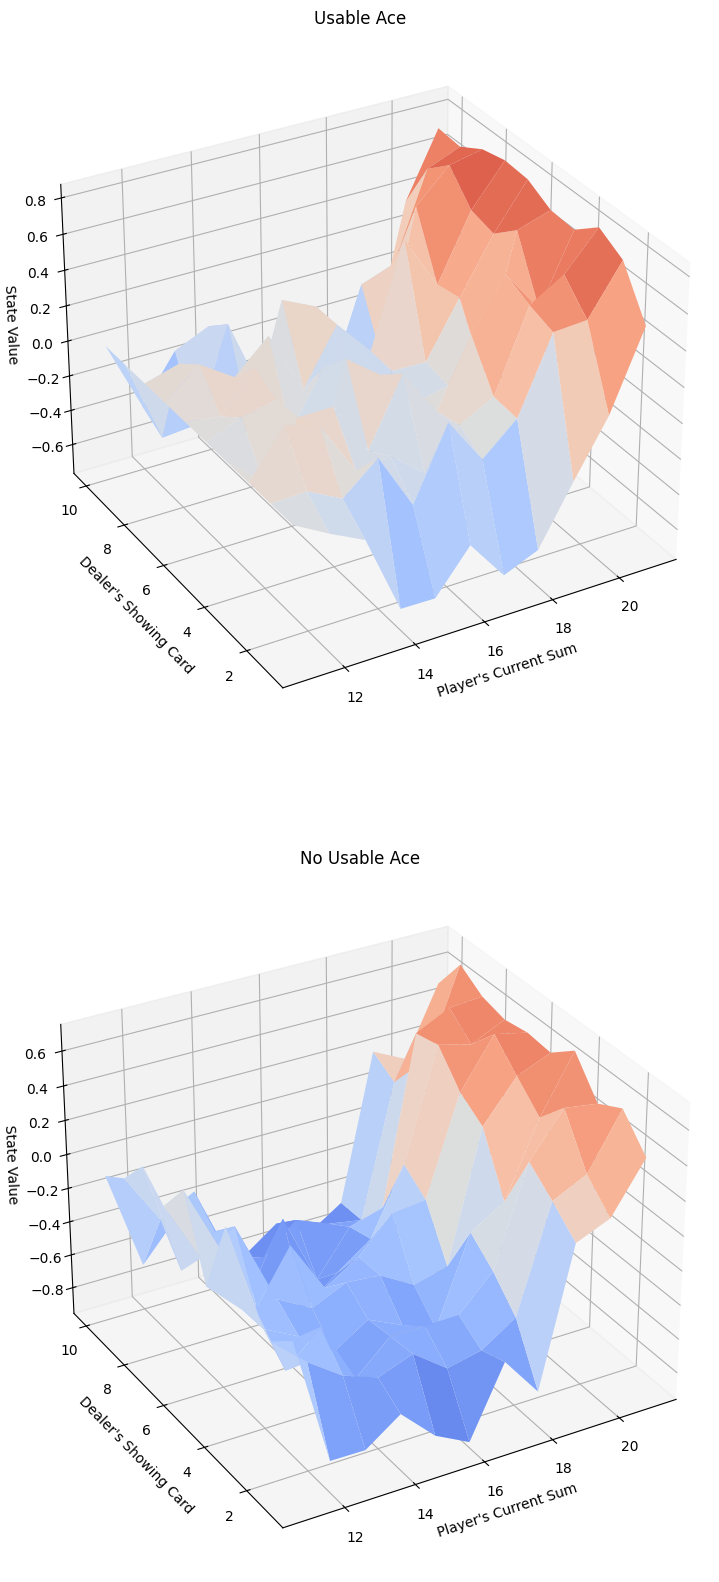

In [16]:
from policy import AlphaMCPolicy

q_table = DictionaryQTable()
q_table.initialize(env.get_action_space().n)

policy = AlphaMCPolicy(q_table, env.get_action_space())

trainer = TrainerMC(policy, env)
trainer.train(50_000)

# obtain the corresponding state-value function
V_to_plot = dict(
    (k, (k[0] > 18) * (np.dot([0.8, 0.2], v)) + (k[0] <= 18) * (np.dot([0.2, 0.8], v)))
    for k, v in q_table.q_values.items()
    if isinstance(k, tuple)
)

# plot the state-value function
plot_blackjack_values(V_to_plot)

In [17]:
n = 50_000
average_reward = trainer.evaluate(n)
n_diff = average_reward * n

# Calculate the number of wins and losses based on n_diff
if n_diff > 0:
    n_losses = (n + n_diff) / 2
    n_wins = n - n_losses
else:
    n_wins = (n - n_diff) / 2
    n_losses = n - n_wins

# Calculate win and loss percentages
win_percentage = (n_wins / n) * 100
loss_percentage = (n_losses / n) * 100

# Print results with percentages
print(f"Win %: {win_percentage:.2f}%")
print(f"Loss %: {loss_percentage:.2f}%")

Evaluation: Average reward over 50000 episodes: -0.11354
Win %: 55.68%
Loss %: 44.32%


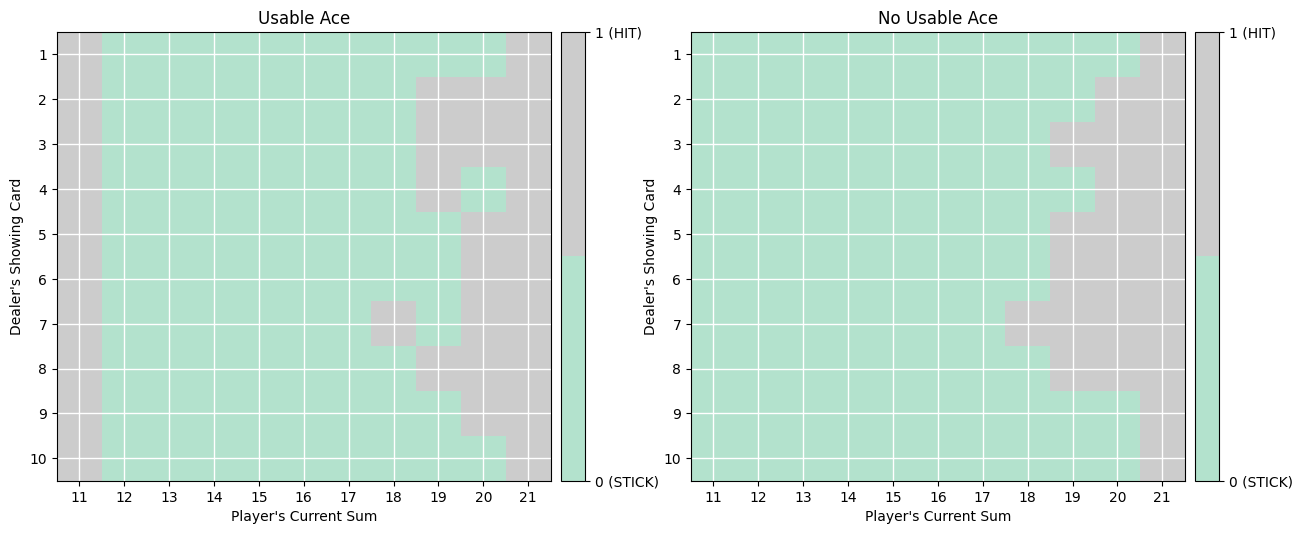

In [18]:
# plot the policy
plot_policy(q_table.q_values)